<a href="https://colab.research.google.com/github/Erickrus/leetcode/blob/master/StableDiffusionPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Models
This is an easy-to-understand implementation of diffusion models within 100 lines of code. Different from other implementations, this code doesn't use the lower-bound formulation for sampling and strictly follows Algorithm 1 from the [DDPM](https://arxiv.org/pdf/2006.11239.pdf) paper, which makes it extremely short and easy to follow. There is only one implementation: `unconditional` in this notebook. Below you can find two explanation videos for the theory behind diffusion models and the implementation.

<a href="https://www.youtube.com/watch?v=HoKDTa5jHvg">
   <img alt="Qries" src="https://user-images.githubusercontent.com/61938694/191407922-f613759e-4bea-4ac9-9135-d053a6312421.jpg"
   width="300">
</a>

<a href="https://www.youtube.com/watch?v=TBCRlnwJtZU">
   <img alt="Qries" src="https://user-images.githubusercontent.com/61938694/191407849-6d0376c7-05b2-43cd-a75c-1280b0e33af1.png"
   width="300">
</a>

<hr>


### prepare CIFAR-10 dataset

In [47]:
#@title download CIFAR-10 dataset
%cd /content
!rm -Rf /content/ddpm
!rm -Rf /content/CIFAR-10-images
!git clone https://github.com/YoongiKim/CIFAR-10-images
!mkdir /content/ddpm


/content
Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Checking out files: 100% (60001/60001), done.


In [8]:
#@title shink dataset size
#@markdown Image to keep per category
imageToKeep = 80 #@param {"type":"integer"}

print("It takes a while, and please wait ...")
import glob, os
for filename in glob.glob("/content/CIFAR-10-images/test/**/*.jpg"):
  shortFilename = os.path.basename(filename).replace(".jpg","")
  fileId = int(shortFilename)
  if fileId >= imageToKeep:
    os.system("rm %s" % filename)
print(len(glob.glob("/content/CIFAR-10-images/test/**/*.jpg")))


It takes a while, and please wait ...
800


### modules.py

In [10]:
#@title SelfAttention
#@markdown self attention
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


In [11]:
#@title DoubleConv
#@markdown double convolution
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)



In [12]:
#@title Down
#@markdown downsample process
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


In [13]:
#@title Up
#@markdown upsample process
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


In [14]:
#@title UNet
#@markdown UNet is $\epsilon_{\theta}(x_t,t)$
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

###utils.py

In [15]:
#@title utils.py
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

#@markdown plot_images
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

#@markdown save_images
def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)
    display(im)

#@markdown get_data
def get_data(args):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
        torchvision.transforms.RandomResizedCrop(args.image_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = torchvision.datasets.ImageFolder(args.dataset_path, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader

#@markdown setup_logging
def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

###Diffusion Class

In [21]:
#@title Re-parameterization Trick
import datetime
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
#import logging
from torch.utils.tensorboard import SummaryWriter

#logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        #@markdown Linear beta model
        self.beta = self.prepare_noise_schedule().to(device)
        #@markdown **Reparameterization Trick**
        #@markdown
        #@markdown $\alpha_t=1-\beta_t$
        self.alpha = 1. - self.beta
        #@markdown $\bar\alpha=\displaystyle\prod^{t}_{s=1}\alpha_s$, accumulative product of $\alpha$
        #@markdown
        #@markdown *Notes: In the code, $\bar\alpha$ is called as alpha_hat, this is not correct*
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)



In [22]:
#@title prepare_noise_schedule, noise_images, sample_timesteps


#@markdown `prepare_noise_schedule()` Linear Schedule
#@markdown
#@markdown > simply using linspace from $\beta_{start}$ to $\beta_{end}$
def prepare_noise_schedule(self):
    #@markdown > If you want to change it to cosine schedule like what OpenAI does, 
    #@markdown > it should be easy to do it here
    return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

#@markdown `noise_images(x, t)`
def noise_images(self, x, t):
    #@markdown > a) samples $\epsilon$ from $N(0,I)$
    e = torch.randn_like(x)
    #@markdown > b) forward process $q(x_t|x_{t-1})$: calculates $x_t=\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon$
    sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
    
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * e, e

#@markdown `sample_timesteps(n)` is to $T \sim Uniform({1,...,T})$
def sample_timesteps(self, n):
    return torch.randint(low=1, high=self.noise_steps, size=(n,))



Diffusion.prepare_noise_schedule = prepare_noise_schedule
Diffusion.noise_images = noise_images
Diffusion.sample_timesteps = sample_timesteps


In [23]:
#@title Algorithm 2 Sampling

def sample(self, model, n):
    print(datetime.datetime.now(), f"sample {n} new images....")
    #@markdown **Algorithm 2 Sampling**        
    model.eval()
    with torch.no_grad():
        #@markdown 1: $x_T \sim N(0,I)$
        #@markdown
        #@markdown the shape is exactly the same as image
        x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
        #@markdown 2: for $t=T,...,1$ do
        #@markdown
        #@markdown that is to execute T times the backward process $p(x_{t-1}|x_t)$ 
        for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
            #@markdown > 3: $z \sim N(0,I)$ if $t>1$, else $z=0$
            t = (torch.ones(n) * i).long().to(self.device)
            #@markdown > 4: $x_{t-1}=\frac{1}{\sqrt{\alpha_t}}(x_t-\frac{1-\alpha_t}{\sqrt{1-\alpha_t}}\epsilon_{\theta}(x_t,t))$
            #@markdown 
            #@markdown > `model(x, t)` or `predicted_noise` is acutally the $\epsilon_{\theta}(x_t,t)$
            predicted_noise = model(x, t)
            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            #@markdown 5: end for
    model.train()
    #@markdown 6: return $x_0$
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

Diffusion.sample = sample

In [24]:
#@title Algorithm 1 Training
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
import logging
from torch.utils.tensorboard import SummaryWriter
import IPython
import numpy as np

def train(args):
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args)
    model = UNet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)
    #@markdown **Algorithm 1 Training**
    #@markdown     
    #@markdown 1: repeat
    for epoch in range(args.epochs):
        #IPython.display.clear_output(wait=True)
        print(datetime.datetime.now(), f"epoch: {epoch}:")
        # load data loops and augument a little bit
        print(datetime.datetime.now(), "train")
        pbar = tqdm(dataloader)
        losses = []
        for i, (images, _) in enumerate(pbar):
            #@markdown > 2: $x_0 \sim q(x_0)$
            #@markdown forward process
            images = images.to(device)            
            #@markdown > 3: $T \sim Uniform({1,...,T})$ 
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            
            #@markdown > 4: $\epsilon \sim N(0,I)$
            #@markdown > 
            #@markdown > `noise_images(images, t)` does 2 things here:
            #@markdown >> 
            #@markdown >> a) samples $\epsilon$ from $N(0,I)$
            #@markdown >> 
            #@markdown >> b) forward process $q(x_t|x_{t-1})$: calculates $x_t=\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon$
            x_t, noise = diffusion.noise_images(images, t)

            #@markdown > 5: Take gradient descent step on
            #@markdown 
            #@markdown >> `predicted_noise = `$\epsilon_{\theta}(\sqrt{\bar\alpha_t}x_0-\sqrt{1-\bar\alpha_t}\epsilon,t)$
            predicted_noise = model(x_t, t)

            #@markdown >> $\nabla_{\theta}||\epsilon - \epsilon_{\theta}(\sqrt{\bar\alpha_t}x_0-\sqrt{1-\bar\alpha_t}\epsilon,t) ||^2 $
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            losses.append(loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)
        print(datetime.datetime.now(), 'loss %.8f' % np.array(losses).mean())
        
        # sample process is extremely time consuming, only execute once every 10 epochs
        if not (epoch>0 and epoch%10==0): 
            continue
        #**algorithm 2** is called when predicting
        sampled_images = diffusion.sample(model, n=images.shape[0])
        save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))
    #@markdown 6: until converged
    #@markdown 
    #@markdown we dont have this step here


### Train

/content/ddpm
2022-10-06 07:38:04.461473 epoch: 0:
2022-10-06 07:38:04.461603 train


100%|██████████| 200/200 [00:35<00:00,  5.68it/s, MSE=0.0747]


2022-10-06 07:38:39.668905 loss 0.19626181
2022-10-06 07:38:39.669128 epoch: 1:
2022-10-06 07:38:39.669166 train


100%|██████████| 200/200 [00:33<00:00,  6.01it/s, MSE=0.0446]


2022-10-06 07:39:12.958104 loss 0.06084056
2022-10-06 07:39:12.958913 epoch: 2:
2022-10-06 07:39:12.958972 train


100%|██████████| 200/200 [00:33<00:00,  5.98it/s, MSE=0.0287]


2022-10-06 07:39:46.405996 loss 0.04395297
2022-10-06 07:39:46.406154 epoch: 3:
2022-10-06 07:39:46.406207 train


100%|██████████| 200/200 [00:33<00:00,  5.94it/s, MSE=0.0163]


2022-10-06 07:40:20.077543 loss 0.03679429
2022-10-06 07:40:20.078077 epoch: 4:
2022-10-06 07:40:20.078122 train


100%|██████████| 200/200 [00:33<00:00,  5.90it/s, MSE=0.0203]


2022-10-06 07:40:53.993574 loss 0.02845562
2022-10-06 07:40:53.995947 epoch: 5:
2022-10-06 07:40:53.996004 train


100%|██████████| 200/200 [00:34<00:00,  5.84it/s, MSE=0.0121]


2022-10-06 07:41:28.240373 loss 0.02897122
2022-10-06 07:41:28.240586 epoch: 6:
2022-10-06 07:41:28.240623 train


100%|██████████| 200/200 [00:34<00:00,  5.87it/s, MSE=0.0326]


2022-10-06 07:42:02.319517 loss 0.02340002
2022-10-06 07:42:02.319702 epoch: 7:
2022-10-06 07:42:02.319740 train


100%|██████████| 200/200 [00:34<00:00,  5.86it/s, MSE=0.0237]


2022-10-06 07:42:36.447761 loss 0.02328044
2022-10-06 07:42:36.450442 epoch: 8:
2022-10-06 07:42:36.450505 train


100%|██████████| 200/200 [00:34<00:00,  5.84it/s, MSE=0.0307]


2022-10-06 07:43:10.722552 loss 0.02211619
2022-10-06 07:43:10.722743 epoch: 9:
2022-10-06 07:43:10.722781 train


100%|██████████| 200/200 [00:34<00:00,  5.82it/s, MSE=0.0856]


2022-10-06 07:43:45.093306 loss 0.02410219
2022-10-06 07:43:45.093508 epoch: 10:
2022-10-06 07:43:45.093546 train


100%|██████████| 200/200 [00:34<00:00,  5.84it/s, MSE=0.0296]


2022-10-06 07:44:19.356535 loss 0.02036360
2022-10-06 07:44:19.356742 sample 4 new images....


999it [00:55, 18.01it/s]


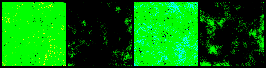

2022-10-06 07:45:15.045708 epoch: 11:
2022-10-06 07:45:15.047157 train


100%|██████████| 200/200 [00:34<00:00,  5.79it/s, MSE=0.00664]


2022-10-06 07:45:49.596676 loss 0.01782811
2022-10-06 07:45:49.596858 epoch: 12:
2022-10-06 07:45:49.596891 train


100%|██████████| 200/200 [00:34<00:00,  5.84it/s, MSE=0.00982]


2022-10-06 07:46:23.852719 loss 0.01902352
2022-10-06 07:46:23.852898 epoch: 13:
2022-10-06 07:46:23.852933 train


100%|██████████| 200/200 [00:34<00:00,  5.84it/s, MSE=0.0256]


2022-10-06 07:46:58.084033 loss 0.01802868
2022-10-06 07:46:58.084237 epoch: 14:
2022-10-06 07:46:58.084274 train


 87%|████████▋ | 174/200 [00:29<00:04,  5.72it/s, MSE=0.00636]

In [ ]:
#@title execute the training process
%cd /content/ddpm

def launch_train():
    import argparse
    #parser = argparse.ArgumentParser()
    #args = parser.parse_args()
    class Args():
      def __init__(self):
        self.run_name = "DDPM_Uncondtional"
        self.epochs = 100
        self.batch_size = 4
        self.image_size = 64
        self.dataset_path = r"/content/CIFAR-10-images/test"
        self.device = "cuda"
        self.lr = 3e-4
    train(Args())

launch_train()
